In [1]:
import sys
sys.path.append('/home/greg/GitHub/')
import pyEDIutils.changes as edi
import pyEDIutils.audit_rpts as edia
import pandas as pd
import numpy as np
import datetime as dt

In [2]:
# Set some parameters
start_rpt = '2021-12-01'
end_rpt = '2022-12-01'
annrpt_year = '2022'

## Archive a request for earlier data

Do this if needed to update the request archives to create a full year dataset for the current report .

In [2]:
# Only do this if it isn't archived yet!
edi.archive_requested('2022-01-02', '2022-05-31')

Requesting PASTA changes for knb-lter-jrn from 2022-01-01 to 2022-05-31
https://pasta.lternet.edu/package/changes/eml?fromDate=2022-01-01&toDate=2022-05-31&scope=knb-lter-jrn
Archiving request at ./edi_requests/knb-lter-jrn_20220101-20220531.xml


## Load archived requests and most recent data

In [3]:
archived = edi.load_archived_changes()

Reading archived PASTA request knb-lter-jrn_20150417-20181231.xml
Reading archived PASTA request knb-lter-jrn_20190101-20191231.xml
Reading archived PASTA request knb-lter-jrn_20200101-20200601.xml
Reading archived PASTA request knb-lter-jrn_20200602-20201201.xml
Reading archived PASTA request knb-lter-jrn_20201202-20210601.xml
Reading archived PASTA request knb-lter-jrn_20210602-20220101.xml
Reading archived PASTA request knb-lter-jrn_20220102-20220531.xml
9 duplicate records were removed.


In [4]:
# Find the last PASTA entry in the archive and convert to datetime
last_archived = pd.to_datetime(archived.date.iloc[-1])

In [5]:
# If the last_archived  value is less than report endtime, get the most recent
# changes (default is retrieve to today) and concatenate to archived requests
if last_archived < pd.to_datetime(end_rpt):
    last_archived_plus1d = last_archived.date() + pd.DateOffset(1)
    # Request changes from last archive to enddate
    new = edi.request_changes(last_archived_plus1d.isoformat())
    # Concat
    df = pd.concat([archived, new])
else:
    df = archived.copy()
    

Requesting PASTA changes for knb-lter-jrn from 2022-05-27T00:00:00 to None
https://pasta.lternet.edu/package/changes/eml?fromDate=2022-05-27T00%3A00%3A00&toDate=2022-11-29&scope=knb-lter-jrn
0 duplicate records were removed.


In [6]:
# Now create datetime index and subset dataframe
df.index = pd.to_datetime(df['date'])
df = df.loc[start_rpt:end_rpt]

In [7]:
# Convert raw data to counts
df = edi.get_counts(df)
df.head()

,date,pkgid,action,n_update,n_create,n_delete,n_tot,studyid
date,,,,,,,,
2021-12-07 22:41:20.355,2021-12-07T22:41:20.355,210015002,updateDataPackage,1,0,0,0,015
2021-12-07 22:45:21.918,2021-12-07T22:45:21.918,210015003,updateDataPackage,1,0,0,0,015
2021-12-08 06:30:53.465,2021-12-08T06:30:53.465,210015001,updateDataPackage,1,0,0,0,015
2021-12-08 18:07:27.537,2021-12-08T18:07:27.537,210548025,updateDataPackage,1,0,0,0,548
2021-12-08 18:21:20.380,2021-12-08T18:21:20.38,210548010,updateDataPackage,1,0,0,0,548


In [8]:
# note that this returns a dataframe with a datetime index
daily = edi.counts_to_daily(df)
daily

,n_update,n_create,n_tot
date,,,
2021-12-07,2,0,0
2021-12-08,75,0,0
2021-12-09,31,0,0
2021-12-10,0,0,0
2021-12-11,0,0,0
...,...,...,...
2022-11-24,0,0,0
2022-11-25,0,0,0
2022-11-26,0,0,0


## Plot activity for annual report


In [9]:
import matplotlib
import matplotlib.pyplot as plt
# Figure config
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

# Get a datestamp for saving figures
import datetime
now = datetime.datetime.now().strftime("%Y%m%d")

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


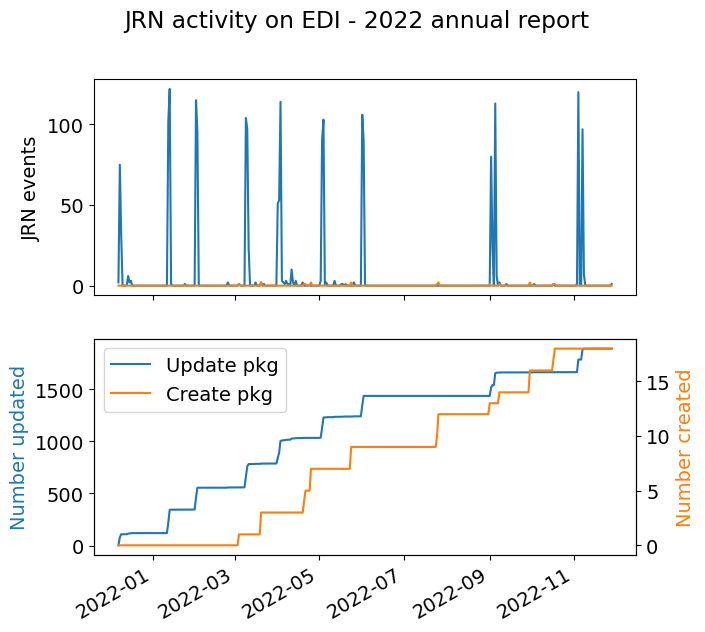

In [10]:
# All time plot:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 7), sharex=True)

ax[0].plot(daily.index, daily.n_update, label='Update pkg')
ax[0].plot(daily.index, daily.n_create, label='Create pkg')
ax[0].set_ylabel('JRN events')

ax[1].plot(daily.index, daily.n_update.cumsum(), label='Update pkg')
plt.ylabel('Number updated', color='C0')
ax2 = ax[1].twinx()
ax2.plot(daily.index, daily.n_create.cumsum(), label='Create pkg', color='C1')
#ax[1].plot(daily.index, daily.n_tot.cumsum(), label='Total')

plt.ylabel('Number created', color='C1')
fig.autofmt_xdate()
plt.suptitle('JRN activity on EDI - {0} annual report'.format(annrpt_year))
lines, labels = ax[1].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
import os
fig.savefig(os.path.expanduser("~/GD_gmaurer@nmsu/IM/figures/JRN_EDI_{0}_ann_rpt_{1}.png".format(annrpt_year, now)),
            dpi=150, bbox_inches='tight',facecolor='w')

### Total number of packages

In [11]:
daily.n_create.sum()

18

In [12]:
daily.n_update.sum()

1890

## Plot annual activity excluding Met

In [13]:
nomet = np.logical_and(df.studyid!='437', df.studyid!='548')
daily_nomet = edi.counts_to_daily(df.loc[nomet], fromdt=start_rpt)

daily_nomet.head()

,n_update,n_create,n_tot
date,,,
2021-12-07,2,0,0
2021-12-08,1,0,0
2021-12-09,2,0,0
2021-12-10,0,0,0
2021-12-11,0,0,0


### Total number of packages

In [14]:
daily_nomet.n_create.sum()

18

In [15]:
daily_nomet.n_update.sum()

74

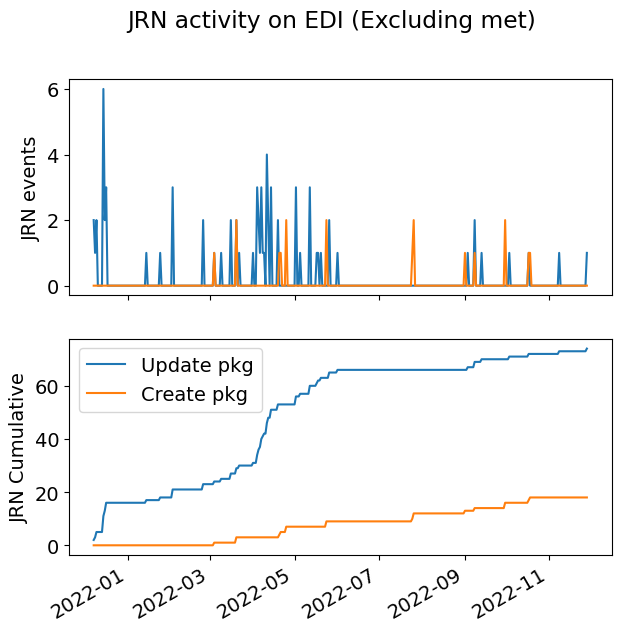

In [16]:
# Recent plot:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 7), sharex=True)

ax[0].plot(daily_nomet.index, daily_nomet.n_update, label='Update pkg')
ax[0].plot(daily_nomet.index, daily_nomet.n_create, label='Create pkg')
ax[0].set_ylabel('JRN events')

ax[1].plot(daily_nomet.index, daily_nomet.n_update.cumsum(), label='Update pkg')
ax[1].plot(daily_nomet.index, daily_nomet.n_create.cumsum(), label='Create pkg')
#ax[1].plot(daily_nomet.index, daily_nomet.n_tot.cumsum(), label='$\Delta$ Total')
#ax[1].axhline(y=63, xmin=0, xmax=1, ls=':', lw=1.5, color='k',
#             label='Proposal goal')

plt.ylabel('JRN Cumulative')
fig.autofmt_xdate()
plt.suptitle('JRN activity on EDI (Excluding met)')
plt.legend()

fig.savefig(os.path.expanduser(
    "~/GD_gmaurer@nmsu/IM/figures/JRN_EDI_{0}_ann_rpt_NoMet_{1}.png".format(annrpt_year, now)),
            dpi=150, bbox_inches='tight',facecolor='w')

## Summary since last Annual Report

In [17]:
df.head()

,date,pkgid,action,n_update,n_create,n_delete,n_tot,studyid
date,,,,,,,,
2021-12-07 22:41:20.355,2021-12-07T22:41:20.355,210015002,updateDataPackage,1,0,0,0,015
2021-12-07 22:45:21.918,2021-12-07T22:45:21.918,210015003,updateDataPackage,1,0,0,0,015
2021-12-08 06:30:53.465,2021-12-08T06:30:53.465,210015001,updateDataPackage,1,0,0,0,015
2021-12-08 18:07:27.537,2021-12-08T18:07:27.537,210548025,updateDataPackage,1,0,0,0,548
2021-12-08 18:21:20.380,2021-12-08T18:21:20.38,210548010,updateDataPackage,1,0,0,0,548


In [18]:
# Unique packages updated (excluding met)
rEDI = df.copy()
rEDI_nomet = rEDI.loc[np.logical_and(rEDI.studyid!='437', rEDI.studyid!='548'),:]
print(len(rEDI.loc[rEDI.action=='updateDataPackage',]))
uniqueUp = rEDI.loc[rEDI.action=='updateDataPackage',].pkgid.unique()
uniqueUp_nomet = rEDI_nomet.loc[rEDI_nomet.action=='updateDataPackage',].pkgid.unique()
#rEDI.loc[rEDI.action=='updateDataPackage',].pkgid.unique()
print(uniqueUp)
print(uniqueUp_nomet)
print(len(uniqueUp))
len(uniqueUp_nomet)

1890
[210015002 210015003 210015001 210548025 210548010 210548040 210548070
 210548085 210548055 210548099 210548026 210548011 210548041 210548071
 210548086 210548056 210548100 210548027 210548061 210548076 210548046
 210548017 210548002 210548032 210548062 210548077 210548047 210548091
 210548018 210548003 210548033 210548063 210548078 210548048 210548092
 210548019 210548004 210548034 210548064 210548079 210548049 210548093
 210548020 210548005 210548035 210548065 210548080 210548050 210548094
 210548021 210548006 210548036 210548066 210548081 210548051 210548095
 210548022 210548007 210548037 210548067 210548082 210548052 210548096
 210548023 210548008 210548038 210548068 210548083 210548053 210548097
 210548024 210548009 210548039 210548069 210548084 210548054 210548098
 210548012 210548042 210548072 210548087 210548057 210548028 210548013
 210548043 210548073 210548088 210548058 210548101 210548029 210548014
 210548044 210548074 210548089 210548059 210548102 210548030 210548015
 

56

In [19]:
pkgtbl = pd.DataFrame({'Total':[daily.n_create.sum(), daily.n_update.sum(),len(uniqueUp)],
                       'Non-Met':[daily_nomet.n_create.sum(), daily_nomet.n_update.sum(),len(uniqueUp_nomet)]})
pkgtbl.index = ['New packages created', 'Package updates', 'Unique package updates']

print(pkgtbl)
# Write it
with open('tables_out/{}_annrpt_edi.csv'.format(annrpt_year), 'w') as f:
    f.write(pkgtbl.to_csv())

                        Total  Non-Met
New packages created       18       18
Package updates          1890       74
Unique package updates    279       56


In [20]:
uniqueUp2 = ['https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=' + str(s)
             for s in uniqueUp]
with open('tables_out/{0}AR_unique_EDI_updates_{1}.txt'.format(annrpt_year, now), 'w') as f:
    for item in uniqueUp2:
        f.write("%s\n" % item)
        
uniqueUp2


['https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210015002',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210015003',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210015001',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210548025',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210548010',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210548040',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210548070',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210548085',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210548055',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210548099',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210548026',

## Audit reporting

In [21]:
edia.request_audit(210011003)

Requesting access data for knb-lter-jrn.210011003
https://pasta.lternet.edu/audit/reads/knb-lter-jrn/210011003

    


,scope,identifier,revision,resource,total_reads,non_robot_reads
0,knb-lter-jrn,210011003,60,data,11,11
1,knb-lter-jrn,210011003,60,metadata,296,294
2,knb-lter-jrn,210011003,60,report,43,43
3,knb-lter-jrn,210011003,60,dataPackage,113,111
4,knb-lter-jrn,210011003,63,archive,1,1
5,knb-lter-jrn,210011003,63,metadata,389,384
6,knb-lter-jrn,210011003,63,data,21,21
7,knb-lter-jrn,210011003,63,report,64,63
8,knb-lter-jrn,210011003,63,dataPackage,226,222
9,knb-lter-jrn,210011003,101,dataPackage,786,758


In [22]:
# Get credentials - these could be anywhere....
import pyEDIutils.edicred as cred

In [23]:
# Get public data downloads for a scope from EDI audit report
# Sometimes this takes 2 tries
test = edia.request_audit_report('readDataEntity', cred.dn, cred.pw,
                               user='public', group=None,resid='knb-lter-jrn',
                               fromdt=start_rpt, todt=end_rpt,lim=100000)

Requesting audit report for knb-lter-jrn starting 2021-12-01
https://pasta.lternet.edu/audit/report/?category=info&service=DataPackageManager-1.0&serviceMethod=readDataEntity&user=public&authSystem=https%3A%2F%2Fpasta.edirepository.org%2Fauthentication&resourceId=knb-lter-jrn&fromTime=2021-12-01&toTime=2022-12-01&limit=100000




In [43]:
# What are the unique useragents and which should we screen out?
#test.useragent.unique()

array(['Mozilla/5.0 (Macintosh; Intel Mac OS X 10.13; rv:94.0) Gecko/20100101 Firefox/94.0',
       'Python-urllib/2.7',
       'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:94.0) Gecko/20100101 Firefox/94.0',
       'Mozilla/5.0 (X11; Linux x86_64; rv:78.0) Gecko/20100101 Firefox/78.0',
       'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.45 Safari/537.36',
       'curl/7.55.1',
       'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.55 Safari/537.36 Edg/96.0.1054.43',
       'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/12.1.2 Safari/605.1.15',
       'python-requests/2.25.1', 'python-requests/2.22.0',
       'DataONE-Python/3.4.7 +http://dataone.org/',
       'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.93 Safari/537.36',
       'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) 

In [24]:
#Exclude DataOne, curl, and python-request agents, which are most likely not 'real users'
searchfor = ['DataONE', 'python-requests', 'curl']
auto_agents = test.useragent.str.contains('|'.join(searchfor), regex=True)
print(len(test))
test_filt = test.loc[~auto_agents, :]
print(len(test_filt))

19039
10777


In [25]:
# Calculate the daily values
test_filt.index = pd.to_datetime(test_filt.entry_dt)
test_filt['n'] = 1
print('Average daily public downloads: ', test_filt.shape[0]/365)
test_filt.head()

Average daily public downloads:  29.526027397260275


/tmp/ipykernel_186001/1446458488.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_filt['n'] = 1


,entry_dt,method,resource_id,user,group,useragent,n
entry_dt,,,,,,,
2021-12-01 02:15:13,2021-12-01T02:15:13,readDataEntity,https://pasta.lternet.edu/package/data/eml/knb...,public,None,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.13; ...,1
2021-12-01 10:53:08,2021-12-01T10:53:08,readDataEntity,https://pasta.lternet.edu/package/data/eml/knb...,public,None,Python-urllib/2.7,1
2021-12-01 11:07:57,2021-12-01T11:07:57,readDataEntity,https://pasta.lternet.edu/package/data/eml/knb...,public,None,Python-urllib/2.7,1
2021-12-01 12:46:13,2021-12-01T12:46:13,readDataEntity,https://pasta.lternet.edu/package/data/eml/knb...,public,None,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:9...,1
2021-12-01 14:34:39,2021-12-01T14:34:39,readDataEntity,https://pasta.lternet.edu/package/data/eml/knb...,public,None,Mozilla/5.0 (X11; Linux x86_64; rv:78.0) Gecko...,1


In [26]:
dl = test_filt.n.resample('D').count()
dl.head()

entry_dt
2021-12-01    5
2021-12-02    0
2021-12-03    2
2021-12-04    0
2021-12-05    0
Freq: D, Name: n, dtype: int64

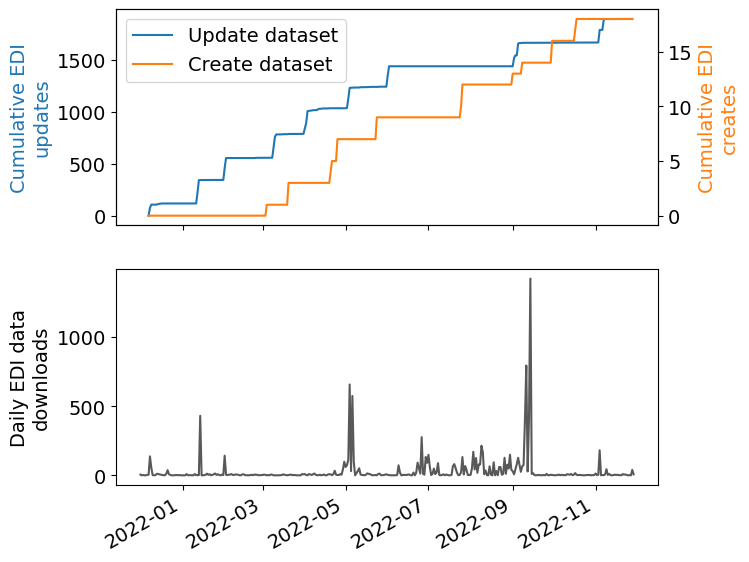

In [27]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 7), sharex=True)

ax[0].plot(daily.index, daily.n_update.cumsum(), label='Update dataset')
ax2 = ax[0].twinx()
ax2.plot(daily.index, daily.n_create.cumsum(), label='Create dataset', color='C1')
ax[0].set_ylabel('Cumulative EDI\nupdates', color='C0')
ax2.set_ylabel('Cumulative EDI\ncreates', color='C1')
#ax[0].legend()
lines, labels = ax[0].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

ax[1].plot(dl, label='Download pkg', color='0.35')
#ax[1].plot(dl.index, daily_nomet.n_create.cumsum(), label='Create pkg')
#ax[1].plot(daily_nomet.index, daily_nomet.n_tot.cumsum(), label='$\Delta$ Total')
#ax[1].axhline(y=63, xmin=0, xmax=1, ls=':', lw=1.5, color='k',
#             label='Proposal goal')

ax[1].set_ylabel('Daily EDI data\ndownloads')
fig.autofmt_xdate()
fig.savefig(os.path.expanduser(
    "~/GD_gmaurer@nmsu/IM/figures/JRN_EDI_{0}_ann_rpt2_{1}.png".format(annrpt_year,now)),
            dpi=150, bbox_inches='tight',facecolor='w')

## Get a list of packages updated within the date range

NOTE: this only works for the current annual report! Many packages get updated once per year at least, so they don't show up when running a previous year annual report.

The list is still available in the yearly "AR_unique_EDI_updates.csv"

If we could check prior revisions....

In [28]:
st = pd.to_datetime(start_rpt).isoformat() + 'Z'
en = pd.to_datetime(end_rpt).isoformat() + 'Z'
en

'2022-12-01T00:00:00Z'

In [29]:
import pyEDIutils.search as edis
updates = edis.search_pasta(query=['scope:knb-lter-jrn', 'pubdate:[{0} TO {1}]'.format(st, en)],
                  fields=('packageid','title','pubdate','keyword','author','begindate','enddate','doi'),
                  sortby='packageid,desc')
updates.to_csv('tables_out/{0}_PASTA_updates_solrsearch_{1}.csv'.format(annrpt_year, now))
updates

https://pasta.lternet.edu/package/search/eml?defType=edismax&q=%2A&fq=scope%3Aknb-lter-jrn&fq=pubdate%3A%5B2021-12-01T00%3A00%3A00Z+TO+2022-12-01T00%3A00%3A00Z%5D&fl=packageid%2Ctitle%2Cpubdate%2Ckeyword%2Cauthor%2Cbegindate%2Cenddate%2Cdoi&sort=packageid%2Cdesc&rows=500


,packageid,title,pubdate,keywords,authors,begindate,enddate,doi
0,knb-lter-jrn.210574002.2,Observed phenological indicators and environme...,2022,disturbance;primary production;climate;climate...,"Currier, Courtney;Sala, Osvaldo E",2014-03-17,2020-12-31,doi:10.6073/pasta/d327a77f6474131db8aa589011e2...
1,knb-lter-jrn.210574001.2,Daily phenocam image data and derived timeseri...,2022,disturbance;primary production;climate;climate...,"Currier, Courtney;Sala, Osvaldo E",2014-03-17,2020-12-31,doi:10.6073/pasta/836360dce9311130383c9672e836...
2,knb-lter-jrn.210548103.24,Jornada Basin LTER Cross-scale Interactions St...,2022,detailed precipitation;meteorology;precipitati...,"Anderson, John",2017-08-11,2022-10-25,doi:10.6073/pasta/9f7102fedaa6485c54334f1fb6e9...
3,knb-lter-jrn.210548102.23,Jornada Basin LTER Cross-scale Interactions St...,2022,detailed precipitation;meteorology;precipitati...,"Anderson, John",2017-08-11,2022-10-24,doi:10.6073/pasta/f00ba54785c29c2a8c4ff0c593d3...
4,knb-lter-jrn.210548101.24,Jornada Basin LTER Cross-scale Interactions St...,2022,detailed precipitation;meteorology;precipitati...,"Anderson, John",2017-08-11,2022-10-24,doi:10.6073/pasta/387d72e935189043ea1186519bd6...
...,...,...,...,...,...,...,...,...
283,knb-lter-jrn.200045001.3,Manure Cycling Interview Data,2022,crop-livestock integration;manureshed;LTAR;ani...,"Meredith, Gwendwr R;Spiegal, Sheri;Kleinman, P...",2020-07-03,2020-12-02,doi:10.6073/pasta/d6adbc29d37e569e053ac74a8e14...
284,knb-lter-jrn.200030002.2,Grass-fed beef producers and retailers map,2022,beef retailers;grass-fed beef;LTAR;Southern Pl...,"Aney, Skye;Elias, Emile;Ramsey, Paige;Cisneros...",2020-07-01,2020-08-31,doi:10.6073/pasta/3eea3acd4e873b8514d8261a4d69...
285,knb-lter-jrn.200029001.2,Baseline survey for beef cattle producers in t...,2022,heritage cattle;LTAR;beef cattle;cattle produc...,"Elias, Emile;Aney, Skye;Duff, Glenn;Gifford, C...",2020-01-22,2021-05-31,doi:10.6073/pasta/7d61e257d0ad7ebd00db2b4c38cc...
286,knb-lter-jrn.200022001.3,Criollo and Crossbred Steer Comparison: Weight...,2022,phenology;LTAR;Raramuri Criollo;grazing distri...,"McIntosh, Matt M;Cibils, Andres F;Estell, Rick...",2015-12-01,2017-01-31,doi:10.6073/pasta/66ffe320906785bb708c55a61787...
